In [1]:
import os
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import torch
from utils import norm_col_nme, get_list_of_tweets, get_sentiments_for_row

# Feature Engineering

In [2]:
curr_dir = os.getcwd()
df = pd.read_csv(os.path.join(curr_dir, "data/stock_tweets.csv"))
df2 = pd.read_csv(os.path.join(curr_dir, "data/stock_yfinance_data.csv"))

In [3]:
df = norm_col_nme(df)
df2 = norm_col_nme(df2)
print(df.date.dtype, df2.date.dtype)

# convert date col for joins
df2.date = pd.to_datetime(df2.date, format="%Y-%m-%d", utc=False)
df.date = pd.to_datetime(pd.to_datetime(df.date, utc=False).dt.date)
print(df.date.dtype, df2.date.dtype)

object object
datetime64[ns] datetime64[ns]


## Tranformation on tweet df

In [4]:
df

,date,tweet,stock_name,company_name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [5]:
# agg tweets by date and stock name
agg_df = df.groupby(["stock_name", "date"])["tweet"].agg(" ".join).reset_index()
display(agg_df.head())

,stock_name,date,tweet
0,AAPL,2021-09-30,"I need 1,000 shares of $AAPL Returns over the ..."
1,AAPL,2021-10-01,The Results! #LottoFriday\n\n$AAPL 141P | .65 ...
2,AAPL,2021-10-02,Current holdings since ppl asked:\n$gogo\n$ntn...
3,AAPL,2021-10-03,2/ The biggest challenge getting active manage...
4,AAPL,2021-10-04,$FB $AAPL $AMZN $MSFT $GOOGL https://t.co/1UWL...


In [13]:
# pre transformation
display(df[(df.stock_name == "AAPL") & (df.date == pd.to_datetime("2021-09-30"))])

# post transformation
display(agg_df.head())
display(get_list_of_tweets(agg_df, "AAPL", "2021-09-30"))

,date,tweet,stock_name,company_name
61007,2021-09-30,"I need 1,000 shares of $AAPL",AAPL,Apple Inc.
61008,2021-09-30,Returns over the last 10 Years:\n\nBitcoin $BT...,AAPL,Apple Inc.
61009,2021-09-30,"All about this trendline now on $AAPL, continu...",AAPL,Apple Inc.
61010,2021-09-30,This thread is just a broad overview of the ba...,AAPL,Apple Inc.
61011,2021-09-30,"In 2020, Tim Cook, CEO of $AAPL, earned $265,0...",AAPL,Apple Inc.
61012,2021-09-30,The media is really pushing hard for their big...,AAPL,Apple Inc.
61013,2021-09-30,I bought my first $AAPL stock in 2010. \n\nSin...,AAPL,Apple Inc.


,stock_name,date,tweet
0,AAPL,2021-09-30,"I need 1,000 shares of $AAPL Returns over the ..."
1,AAPL,2021-10-01,The Results! #LottoFriday\n\n$AAPL 141P | .65 ...
2,AAPL,2021-10-02,Current holdings since ppl asked:\n$gogo\n$ntn...
3,AAPL,2021-10-03,2/ The biggest challenge getting active manage...
4,AAPL,2021-10-04,$FB $AAPL $AMZN $MSFT $GOOGL https://t.co/1UWL...


"I need 1,000 shares of $AAPL Returns over the last 10 Years:\n\nBitcoin $BTC: +994,608%\nTesla $TSLA: +15,200%\nNVIDIA $NVDA: +6,053%\nNetflix $NFLX: +2,337%\nAmazon $AMZN: +1,427%\nApple $AAPL: +1,112%\nS&amp;P 500 $SPY: +344%\nBonds $AGG: +35%\nGold $GLD: -6%\n\n@PeterSchiff literally picked the worst performing asset. All about this trendline now on $AAPL, continuing to reject it. https://t.co/DDQ9fL0acY This thread is just a broad overview of the balance sheet\n\nWant specifics &amp; and a helpful example?\n\nWe did a deep dive into the balance sheet on my YouTube channel using $AAPL's recent numbers as an example\n\nhttps://t.co/BTWrUomWe8 In 2020, Tim Cook, CEO of $AAPL, earned $265,000,000 in total compensation.\n\nIn 2020, Warren Buffett earned ~$755,079,143 in dividends from $AAPL. \n\nZERO hours clocked, ZERO meetings &amp; ZERO headaches caused. \n\nInvest. The media is really pushing hard for their big money clients for $tsla options tomorrow. The sh!t they make up is laug

In [14]:
df

,date,tweet,stock_name,company_name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [15]:
df = df.drop(columns="tweet")
df = df.drop_duplicates(["stock_name", "date"])
df_final_df = pd.merge(df, agg_df, on=["stock_name", "date"], how="inner")

In [16]:
df_final_df.drop_duplicates(["stock_name", "date"])

,date,stock_name,company_name,tweet
0,2022-09-29,TSLA,"Tesla, Inc.",Mainstream media has done an amazing job at br...
1,2022-09-28,TSLA,"Tesla, Inc.",$AAPL and $TSLA have seen big inflows from ret...
2,2022-09-27,TSLA,"Tesla, Inc.",Elon making burn jokes is bullish.\n\n$TSLA ht...
3,2022-09-26,TSLA,"Tesla, Inc.","$TSLA Since 2019, legacy auto has made up for ..."
4,2022-09-25,TSLA,"Tesla, Inc.",Reuters reports that Tesla plans to construct ...
...,...,...,...,...
5905,2021-10-09,XPEV,XPeng Inc.,"Update on Apple, Tesla, Nio, $QQQ, $SPY, ROKU,..."
5906,2021-10-07,XPEV,XPeng Inc.,Some of the fastest growing tech stocks on the...
5907,2021-10-04,XPEV,XPeng Inc.,"With earnings on the horizon, here is a quick ..."
5908,2021-10-01,XPEV,XPeng Inc.,Our record delivery results are a testimony of...


## Transformation on stock price df

In [17]:
df2

,date,open,high,low,close,adj_close,volume,stock_name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [18]:
# sorte df by name and date
sorted_df2 = df2.sort_values(by=["stock_name", "date"])
display(sorted_df2.head())

# creating target
df2_targets_df = sorted_df2.shift(-1)
df2_targets_df.columns = [c + "_target" if c not in ("stock_name", "date") else c for c in df2_targets_df.columns ] 
display(df2_targets_df.head())

# merege target
df2_targets_df = df2_targets_df.drop(columns=["date", "stock_name"])

# inspecting target df is correct
df2_final_df = pd.concat([sorted_df2, df2_targets_df], axis=1).dropna()
df2_final_df["if_higher"] = (df2_final_df["open_target"] <= df2_final_df["open"]).astype(int)
display(df2_final_df)

,date,open,high,low,close,adj_close,volume,stock_name
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL


,date,open_target,high_target,low_target,close_target,adj_close_target,volume_target,stock_name
1764,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600.0,AAPL
1765,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000.0,AAPL
1766,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100.0,AAPL
1767,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100.0,AAPL
1768,2021-10-07,143.059998,144.220001,142.720001,143.289993,142.255554,61732700.0,AAPL


,date,open,high,low,close,adj_close,volume,stock_name,open_target,high_target,low_target,close_target,adj_close_target,volume_target,if_higher
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,141.899994,142.919998,139.110001,142.649994,141.620163,94639600.0,1
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,AAPL,141.759995,142.210007,138.270004,139.139999,138.135513,98322000.0,1
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,AAPL,139.490005,142.240005,139.360001,141.110001,140.091278,80861100.0,1
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,AAPL,139.470001,142.149994,138.369995,142.000000,140.974869,83221100.0,1
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,AAPL,143.059998,144.220001,142.720001,143.289993,142.255554,61732700.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6042,2022-09-22,171.149994,173.660004,162.500000,162.559998,162.559998,2068700,ZS,160.259995,162.559998,156.059998,158.690002,158.690002,1987900.0,1
6043,2022-09-23,160.259995,162.559998,156.059998,158.690002,158.690002,1987900,ZS,158.779999,164.380005,158.779999,159.759995,159.759995,1628700.0,1
6044,2022-09-26,158.779999,164.380005,158.779999,159.759995,159.759995,1628700,ZS,163.910004,166.399994,159.990005,163.210007,163.210007,1718300.0,0
6045,2022-09-27,163.910004,166.399994,159.990005,163.210007,163.210007,1718300,ZS,164.000000,169.539993,162.634995,168.779999,168.779999,1723100.0,0


In [19]:
train = pd.merge(df_final_df, df2_final_df, on=["stock_name", "date"], how="inner")
display(train.head())
print(len(train))

,date,stock_name,company_name,tweet,open,high,low,close,adj_close,volume,open_target,high_target,low_target,close_target,adj_close_target,volume_target,if_higher
0,2022-09-29,TSLA,"Tesla, Inc.",Mainstream media has done an amazing job at br...,282.760010,283.649994,265.779999,268.209991,268.209991,77620600,112.430000,113.349998,111.650002,111.650002,109.457535,6433400.0,1
1,2022-09-28,TSLA,"Tesla, Inc.",$AAPL and $TSLA have seen big inflows from ret...,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,282.760010,283.649994,265.779999,268.209991,268.209991,77620600.0,1
2,2022-09-27,TSLA,"Tesla, Inc.",Elon making burn jokes is bullish.\n\n$TSLA ht...,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,283.079987,289.000000,277.570007,287.809998,287.809998,54664800.0,1
3,2022-09-26,TSLA,"Tesla, Inc.","$TSLA Since 2019, legacy auto has made up for ...",271.829987,284.089996,270.309998,276.010010,276.010010,58076900,283.839996,288.670013,277.510010,282.940002,282.940002,61925200.0,0
4,2022-09-23,TSLA,"Tesla, Inc.",Bears This Week\n$SPY $QQQ $TSLA https://t.co/...,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,271.829987,284.089996,270.309998,276.010010,276.010010,58076900.0,1


4183


In [20]:
dataset = train.sort_values(by="date").reset_index(drop=True)
display(dataset)

,date,stock_name,company_name,tweet,open,high,low,close,adj_close,volume,open_target,high_target,low_target,close_target,adj_close_target,volume_target,if_higher
0,2021-09-30,XPEV,XPeng Inc.,Why can XPeng P5 deliver outstanding performan...,35.029999,36.110001,34.816002,35.540001,35.540001,6461500,36.750000,36.759998,35.080002,35.459999,35.459999,7770600.0,0
1,2021-09-30,AMD,"Advanced Micro Devices, Inc.",#LottoFriday Watchlist: short &amp; sweet\n\n$...,102.080002,104.440002,101.989998,102.900002,102.900002,57636700,102.599998,103.000000,100.639999,102.449997,102.449997,41491600.0,0
2,2021-09-30,PG,Procter & Gamble Company,My top 10 holdings make up 66% of my portfolio...,142.639999,142.740005,139.529999,139.800003,135.573044,6934900,139.929993,140.229996,138.320007,139.580002,135.359695,5587200.0,1
3,2021-09-30,AAPL,Apple Inc.,"I need 1,000 shares of $AAPL Returns over the ...",143.660004,144.380005,141.279999,141.500000,140.478485,89056700,141.899994,142.919998,139.110001,142.649994,141.620163,94639600.0,1
4,2021-09-30,GOOG,Alphabet Inc.,Thanks goog https://t.co/PmKvWUYuQn,134.324997,135.589996,133.000000,133.265503,133.265503,35294000,133.554504,137.070999,133.377502,136.462494,136.462494,28388000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,2022-09-29,AMD,"Advanced Micro Devices, Inc.",$MSFT $GOOGL $NVDA $AMD all hit 52W low today....,67.150002,67.199997,62.830002,64.139999,64.139999,102552400,165.800003,166.392502,163.699493,164.251999,164.251999,56848000.0,0
4179,2022-09-29,KO,The Coca-Cola Company,Lower prices in dividend stocks presents highe...,57.090000,57.290001,56.000000,56.570000,56.171619,14570700,340.450012,342.799988,338.149994,339.390015,339.390015,16547100.0,0
4180,2022-09-29,COST,Costco Wholesale Corporation,I mentioned 1 trade today for $COST Puts @ $10...,485.609985,489.010010,474.070007,478.980011,478.116913,1963900,270.649994,274.260010,270.440002,271.220001,271.220001,5224200.0,1
4181,2022-09-29,AAPL,Apple Inc.,$NIO just because I'm down money doesn't mean ...,146.100006,146.720001,140.679993,142.479996,142.244034,128138200,102.080002,104.440002,101.989998,102.900002,102.900002,57636700.0,1


## Adding default Sentiment Score

In [22]:
model_nmes = ["ahmedrachid/FinancialBERT-Sentiment-Analysis",
              "ProsusAI/finbert",
              "StephanAkkerman/FinTwitBERT-sentiment",
              "cardiffnlp/twitter-roberta-base-sentiment-latest"]

model = AutoModel.from_pretrained(model_nmes[3])
tokenizer = AutoTokenizer.from_pretrained(model_nmes[3])

/Users/mariolin/projects/sentiment_analysis_stocks/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
from tqdm import tqdm

hidden_states_df = pd.DataFrame()
all_tweets = dataset.tweet

progress_bar = tqdm(len(all_tweets))
for t in all_tweets:
    mdl_input = tokenizer(t, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        output = model(**mdl_input)
    pooled_output = torch.mean(output.last_hidden_state, dim=1).numpy()[0]
    curr_df = pd.DataFrame(data=[pooled_output], columns=[f"dim_{i}" for i in range(len(pooled_output))])
    hidden_states_df = pd.concat([hidden_states_df, curr_df], axis=0)
    progress_bar.update(1)

4182it [08:02, 10.64it/s]

In [24]:
final_df = pd.concat([dataset.reset_index(drop=True), hidden_states_df.reset_index(drop=True)], axis=1)
display(final_df)

,date,stock_name,company_name,tweet,open,high,low,close,adj_close,volume,...,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767
0,2021-09-30,XPEV,XPeng Inc.,Why can XPeng P5 deliver outstanding performan...,35.029999,36.110001,34.816002,35.540001,35.540001,6461500,...,-0.227989,-0.796935,-0.799074,0.005439,0.276911,0.034739,-0.108935,-0.599620,0.453449,0.542871
1,2021-09-30,AMD,"Advanced Micro Devices, Inc.",#LottoFriday Watchlist: short &amp; sweet\n\n$...,102.080002,104.440002,101.989998,102.900002,102.900002,57636700,...,-0.070838,-0.424373,-0.853124,0.014211,0.354916,0.129065,0.361626,-0.681549,0.068890,0.231864
2,2021-09-30,PG,Procter & Gamble Company,My top 10 holdings make up 66% of my portfolio...,142.639999,142.740005,139.529999,139.800003,135.573044,6934900,...,0.114126,-0.318759,-0.715889,0.057122,0.415961,0.085777,0.435829,-0.638931,-0.052294,0.164085
3,2021-09-30,AAPL,Apple Inc.,"I need 1,000 shares of $AAPL Returns over the ...",143.660004,144.380005,141.279999,141.500000,140.478485,89056700,...,0.267494,-0.203472,-0.448645,-0.139354,0.296561,0.137550,0.522862,-0.419037,-0.261121,0.220874
4,2021-09-30,GOOG,Alphabet Inc.,Thanks goog https://t.co/PmKvWUYuQn,134.324997,135.589996,133.000000,133.265503,133.265503,35294000,...,0.012016,-0.741429,-0.640420,0.516564,0.546404,-0.244143,0.384672,-0.331255,-0.066054,-0.030662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,2022-09-29,AMD,"Advanced Micro Devices, Inc.",$MSFT $GOOGL $NVDA $AMD all hit 52W low today....,67.150002,67.199997,62.830002,64.139999,64.139999,102552400,...,-0.011214,-0.327478,-0.698915,0.138180,0.398733,0.101476,0.329342,-0.685027,-0.067358,0.251040
4179,2022-09-29,KO,The Coca-Cola Company,Lower prices in dividend stocks presents highe...,57.090000,57.290001,56.000000,56.570000,56.171619,14570700,...,0.510765,-0.191932,-0.416639,0.146920,0.245373,-0.102966,0.175178,-0.705163,-0.424680,0.118569
4180,2022-09-29,COST,Costco Wholesale Corporation,I mentioned 1 trade today for $COST Puts @ $10...,485.609985,489.010010,474.070007,478.980011,478.116913,1963900,...,0.388303,-0.247921,-0.331329,0.112060,0.296152,0.183925,0.613988,-0.520468,-0.416870,0.161137
4181,2022-09-29,AAPL,Apple Inc.,$NIO just because I'm down money doesn't mean ...,146.100006,146.720001,140.679993,142.479996,142.244034,128138200,...,0.151520,-0.288518,-0.348091,0.085616,0.378745,-0.000285,0.246981,-0.553319,-0.264875,0.244260


## Partition Data

In [25]:
train_per = 0.8
val_per = 0.1
N = len(final_df)
train_idx, val_idx = int(N * train_per), int(N * (train_per + val_per))

train = final_df.iloc[:train_idx]
val = final_df.iloc[train_idx:val_idx]
test = final_df.iloc[val_idx:]

<Axes: xlabel='stock_name'>

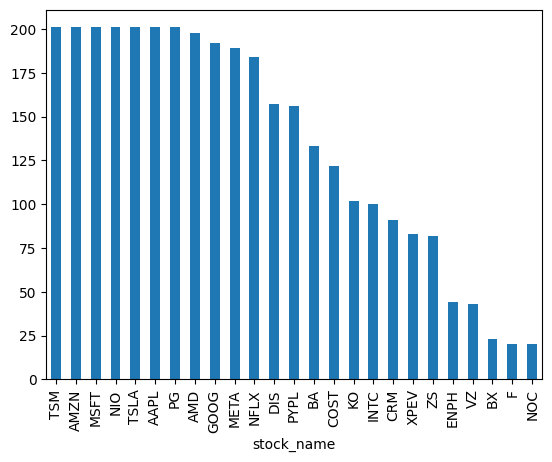

In [26]:
train["stock_name"].value_counts(ascending=False).plot.bar()

In [27]:
train.if_higher.value_counts(normalize=True)

if_higher
0    0.501195
1    0.498805
Name: proportion, dtype: float64

<Axes: xlabel='stock_name'>

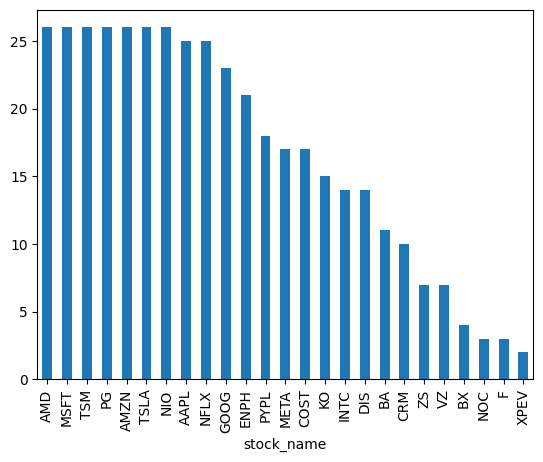

In [28]:
val["stock_name"].value_counts(ascending=False).plot.bar()

In [29]:
val.if_higher.value_counts(normalize=True)

if_higher
0    0.511962
1    0.488038
Name: proportion, dtype: float64

<Axes: xlabel='stock_name'>

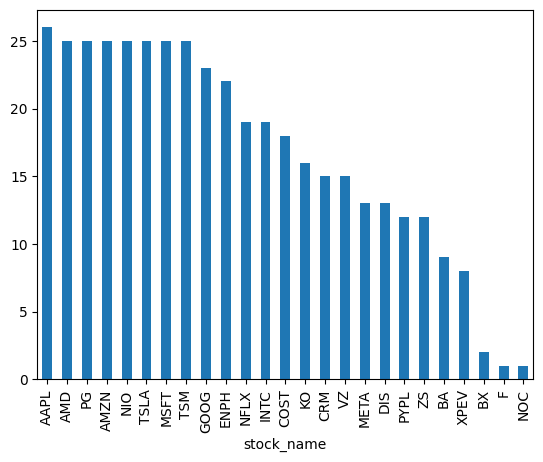

In [30]:
test["stock_name"].value_counts(ascending=False).plot.bar()

In [31]:
test.if_higher.value_counts(normalize=True)

if_higher
1    0.541766
0    0.458234
Name: proportion, dtype: float64

# Save Processed Data

In [32]:
train.to_parquet(os.path.join(curr_dir, "data/train.parquet"))
val.to_parquet(os.path.join(curr_dir, "data/val.parquet"))
test.to_parquet(os.path.join(curr_dir, "data/test.parquet"))

4183it [08:20, 10.64it/s]